<a href="https://colab.research.google.com/github/zhuzz12/cvdl/blob/main/hello_fasterrcnn_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 

In [ ]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

In [ ]:
!pip3 install -q kaggle

os.environ['KAGGLE_USERNAME']="zhuldyzayaitakhunova"
os.environ['KAGGLE_KEY']="79363300b8a38724d93270fd000d3a36"

In [ ]:
# Root directory of the project
ROOT_DIR = os.path.abspath('./pneumonia_detection')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [ ]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [01:40<00:00, 41.8MB/s]
100% 3.66G/3.66G [01:40<00:00, 39.2MB/s]


In [ ]:
!unzip -q -o /content/pneumonia_detection/rsna-pneumonia-detection-challenge.zip -d .

In [ ]:
train_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_test_images')

In [ ]:
import glob, pandas as pd
import matplotlib.pyplot as plt
import pydicom, numpy as np

In [ ]:
df = pd.read_csv(os.path.join(ROOT_DIR, 'stage_2_train_labels.csv'))

In [ ]:
df

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [ ]:
def parse_data(df):
    
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['x'], row['y'], row['x'] + row['width'], row['y'] + row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '%s/%s.dcm' % (train_dicom_dir, pid),
                'label': row['Target'],
                'boxes': [], 
                'patientId': pid}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))
    parsed_df = {'patientId': [], 'dicom': [], 'label': [], 'boxes':[]}

    for key in parsed:
        parsed_df['patientId'].append(parsed[key]['patientId'])
        parsed_df['dicom'].append(parsed[key]['dicom'])
        parsed_df['label'].append(parsed[key]['label'])
        parsed_df['boxes'].append(parsed[key]['boxes'])

    parsed_df = pd.DataFrame(parsed_df)
    return parsed_df

    

df = pd.read_csv('stage_2_train_labels.csv')
patient_class = pd.read_csv('stage_2_detailed_class_info.csv', index_col=0)

parsed_df = parse_data(df)


patientId = parsed_df.loc[5, 'patientId']

print('Just a checking that everything is working fine...')
print(parsed_df.loc[0])
print(patient_class.loc[patientId])


Just a checking that everything is working fine...
patientId                 0004cfab-14fd-4e49-80ba-63a80b6bddd6
dicom        /content/pneumonia_detection/pneumonia_detecti...
label                                                        0
boxes                                                       []
Name: 0, dtype: object
class    No Lung Opacity / Not Normal
Name: 00569f44-917d-4c86-a842-81832af98c30, dtype: object


In [ ]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    plt.imshow(im, cmap=plt.cm.gist_gray)
    plt.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    x1, y1, x2, y2 = box
    #y2 = y1 + height
    #x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im    

class    Normal
Name: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5, dtype: object


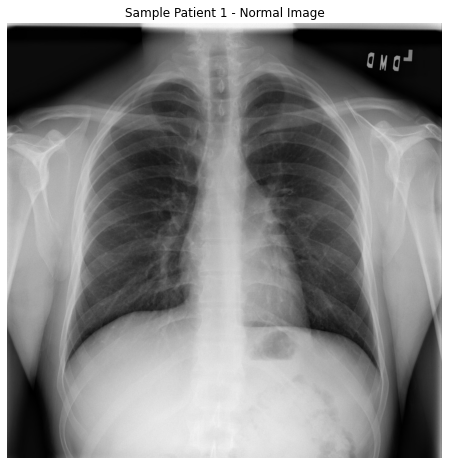

In [ ]:
patientId = parsed_df.loc[3, 'patientId']
print(patient_class.loc[patientId])

plt.figure(figsize=(10,8))
plt.title("Sample Patient 1 - Normal Image")

draw(parsed_df.loc[3])

                                             class
patientId                                         
00aecb01-a116-45a2-956c-08d2fa55433f  Lung Opacity
00aecb01-a116-45a2-956c-08d2fa55433f  Lung Opacity


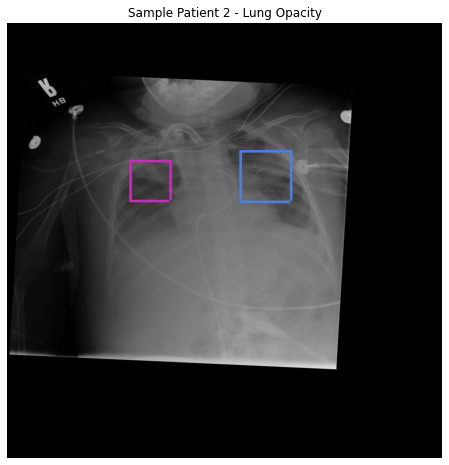

In [ ]:
patientId = parsed_df.loc[12, 'patientId']
print(patient_class.loc[patientId])

plt.figure(figsize=(10,8))
plt.title("Sample Patient 2 - Lung Opacity")

draw(parsed_df.loc[12])

In [ ]:
positive_df = parsed_df[parsed_df.loc[:, 'label'] == 1].reset_index()

positive_df

from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(positive_df, test_size=0.1)

positive_df

,index,patientId,dicom,label,boxes
0,4,00436515-870c-4b36-a041-de91049b9ab4,/content/pneumonia_detection/pneumonia_detecti...,1,"[[264.0, 152.0, 477.0, 365.0], [562.0, 152.0, ..."
1,7,00704310-78a8-4b38-8475-49f4573b2dbb,/content/pneumonia_detection/pneumonia_detecti...,1,"[[323.0, 577.0, 483.0, 737.0], [695.0, 575.0, ..."
2,12,00aecb01-a116-45a2-956c-08d2fa55433f,/content/pneumonia_detection/pneumonia_detecti...,1,"[[288.0, 322.0, 382.0, 416.0], [547.0, 299.0, ..."
3,13,00c0b293-48e7-4e16-ac76-9269ba535a62,/content/pneumonia_detection/pneumonia_detecti...,1,"[[306.0, 544.0, 474.0, 712.0], [650.0, 511.0, ..."
4,15,00f08de1-517e-4652-a04f-d1dc9ee48593,/content/pneumonia_detection/pneumonia_detecti...,1,"[[181.0, 184.0, 387.0, 390.0], [571.0, 275.0, ..."
...,...,...,...,...,...
6007,26670,c18d1138-ba74-4af5-af21-bdd4d2c96bb5,/content/pneumonia_detection/pneumonia_detecti...,1,"[[646.0, 386.0, 787.0, 527.0], [295.0, 473.0, ..."
6008,26675,c1cddf32-b957-4753-acaa-472ab1447e86,/content/pneumonia_detection/pneumonia_detecti...,1,"[[269.0, 416.0, 462.0, 609.0], [766.0, 475.0, ..."
6009,26679,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,/content/pneumonia_detection/pneumonia_detecti...,1,"[[666.0, 418.0, 852.0, 604.0], [316.0, 504.0, ..."
6010,26680,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,/content/pneumonia_detection/pneumonia_detecti...,1,"[[609.0, 464.0, 849.0, 704.0], [185.0, 298.0, ..."


In [ ]:
df_train = df_train.reset_index()
df_train

,level_0,index,patientId,dicom,label,boxes
0,4679,18685,c3b9c35d-19a1-4ce7-b852-e670dce72ddc,/content/pneumonia_detection/pneumonia_detecti...,1,"[[611.0, 395.0, 698.0, 482.0], [606.0, 543.0, ..."
1,3593,16165,ac81e9b6-5789-4797-ad85-510186cdd4a9,/content/pneumonia_detection/pneumonia_detecti...,1,"[[199.0, 142.0, 455.0, 398.0], [542.0, 100.0, ..."
2,1028,2912,39552f5b-ee51-4a9a-9028-8fcdaae9baac,/content/pneumonia_detection/pneumonia_detecti...,1,"[[216.0, 218.0, 456.0, 458.0], [563.0, 139.0, ..."
3,3024,13872,98d96d73-2a33-45a0-a242-dbbad2f2e579,/content/pneumonia_detection/pneumonia_detecti...,1,"[[149.0, 116.0, 358.0, 325.0]]"
4,5785,26059,1a32542e-bc47-4703-82a7-d88bedc8c07d,/content/pneumonia_detection/pneumonia_detecti...,1,"[[219.0, 300.0, 380.0, 461.0], [622.0, 411.0, ..."
...,...,...,...,...,...,...
5405,1916,7849,646917f3-2303-43ef-acac-37470021e91f,/content/pneumonia_detection/pneumonia_detecti...,1,"[[214.0, 479.0, 334.0, 599.0]]"
5406,774,2286,34297b7d-9e22-4e73-b105-a8db72ad36ee,/content/pneumonia_detection/pneumonia_detecti...,1,"[[241.0, 549.0, 418.0, 726.0]]"
5407,1614,5707,51b0e89f-608a-4040-9d0d-694ebe072c28,/content/pneumonia_detection/pneumonia_detecti...,1,"[[213.0, 221.0, 471.0, 479.0], [519.0, 222.0, ..."
5408,2439,10799,7d402380-193a-4aef-92aa-8c80e11217fb,/content/pneumonia_detection/pneumonia_detecti...,1,"[[122.0, 483.0, 320.0, 681.0]]"


In [ ]:
df_val = df_val.reset_index()

df_val

,level_0,index,patientId,dicom,label,boxes
0,3000,13746,97cd19cb-73b1-47df-b60f-380d44fc0ec9,/content/pneumonia_detection/pneumonia_detecti...,1,"[[115.0, 371.0, 405.0, 661.0]]"
1,1696,6359,5759f979-a582-4eea-8056-cc17c85bb984,/content/pneumonia_detection/pneumonia_detecti...,1,"[[786.0, 766.0, 866.0, 846.0]]"
2,2132,9347,70a630f3-c0cd-4487-b07f-87e2bbe961e0,/content/pneumonia_detection/pneumonia_detecti...,1,"[[573.0, 271.0, 784.0, 482.0]]"
3,3858,16813,b217cb57-c3f5-4fab-a81f-48425916ba54,/content/pneumonia_detection/pneumonia_detecti...,1,"[[613.0, 545.0, 849.0, 781.0], [147.0, 675.0, ..."
4,1413,3981,4281b0c0-eab8-428f-893f-06a2291ace68,/content/pneumonia_detection/pneumonia_detecti...,1,"[[597.0, 473.0, 920.0, 796.0]]"
...,...,...,...,...,...,...
597,99,263,06e09ebb-cb5b-4c30-8d3a-67a6ec34692b,/content/pneumonia_detection/pneumonia_detecti...,1,"[[152.0, 129.0, 336.0, 313.0], [577.0, 161.0, ..."
598,5943,26486,2c376b9a-167a-43d3-bcc2-b4af32fb9f74,/content/pneumonia_detection/pneumonia_detecti...,1,"[[280.0, 262.0, 465.0, 447.0]]"
599,4309,17825,bae7b652-311f-4a84-a031-653424887f35,/content/pneumonia_detection/pneumonia_detecti...,1,"[[599.0, 597.0, 818.0, 816.0], [172.0, 596.0, ..."
600,701,2106,328ca6d8-ae49-41ad-9e58-823c8049b1bb,/content/pneumonia_detection/pneumonia_detecti...,1,"[[343.0, 386.0, 448.0, 491.0], [585.0, 413.0, ..."


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PedestrianDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        print(len(df['dicom'].values.tolist()))
        self.imgs = df['dicom'].values.tolist()
        #self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.df.loc[idx, 'dicom']
        #mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        #img = Image.open(img_path).convert("RGB")
        d = pydicom.read_file(img_path)
        img = d.pixel_array
        img = np.stack([img]* 3, axis=2)

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        #mask = Image.open(mask_path)

        #mask = np.array(mask)
        # instances are encoded as different colors
        #obj_ids = np.unique(mask)
        # first id is the background, so remove it
        #obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        #masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        #num_objs = len(obj_ids)
        #boxes =[]
        boxes = self.df.loc[idx, 'boxes']
        num_objs = len(boxes)
        #for i in range(num_objs):
        #    pos = np.where(masks[i])
        #    xmin = np.min(pos[1])
        #    xmax = np.max(pos[1])
        #    ymin = np.min(pos[0])
        #    ymax = np.max(pos[0])
        #    boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        #masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

      
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features fora the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    
    # Stop here if you are fine-tunning Faster-RCNN
    return model


In [ ]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../


Cloning into 'vision'...
remote: Enumerating objects: 267826, done.
remote: Counting objects: 100% (7027/7027), done.
remote: Compressing objects: 100% (383/383), done.
remote: Total 267826 (delta 6660), reused 6975 (delta 6630), pack-reused 260799
Receiving objects: 100% (267826/267826), 540.14 MiB | 29.20 MiB/s, done.
Resolving deltas: 100% (244411/244411), done.
/content/pneumonia_detection/pneumonia_detection/vision
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d8 version check against PyTorch's CUDA version


In [ ]:
%cd ..

/content/pneumonia_detection/pneumonia_detection


In [ ]:
!pwd

/content/pneumonia_detection/pneumonia_detection


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# use our dataset and defined transformations
dataset = PedestrianDataset(df_train, get_transform(train=True))
dataset_test = PedestrianDataset(df_val, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)


5410
602


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)
grads = [p.requires_grad for p in model.parameters()]
print(grads)
print(model)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, 

In [ ]:
def eval_model(model, data_loader_test, device): 
    losses = {'train': [], "val": []}
    IOU_th = 0.5
    tp = 0 
    fp = 0
    fn = 0
    for data in data_loader_test:

        img, target = data

        # put the model in evaluation mode
        model.eval()

        with torch.no_grad():
            prediction = model([img.to(device)])[0]
        
    


In [ ]:
eval_model(model,  data_loader_test, device = device)

({'boxes': tensor([[115., 371., 405., 661.]]), 'labels': tensor([1]), 'image_id': tensor([0]), 'area': tensor([84100.]), 'iscrowd': tensor([0])}, {'boxes': tensor([[786., 766., 866., 846.]]), 'labels': tensor([1]), 'image_id': tensor([1]), 'area': tensor([6400.]), 'iscrowd': tensor([0])})
({'boxes': tensor([[573., 271., 784., 482.]]), 'labels': tensor([1]), 'image_id': tensor([2]), 'area': tensor([44521.]), 'iscrowd': tensor([0])}, {'boxes': tensor([[613., 545., 849., 781.],
        [147., 675., 419., 947.]]), 'labels': tensor([1, 1]), 'image_id': tensor([3]), 'area': tensor([55696., 73984.]), 'iscrowd': tensor([0, 0])})
({'boxes': tensor([[597., 473., 920., 796.]]), 'labels': tensor([1]), 'image_id': tensor([4]), 'area': tensor([104329.]), 'iscrowd': tensor([0])}, {'boxes': tensor([[322., 359., 513., 550.],
        [579., 370., 808., 599.]]), 'labels': tensor([1, 1]), 'image_id': tensor([5]), 'area': tensor([36481., 52441.]), 'iscrowd': tensor([0, 0])})
({'boxes': tensor([[ 83., 312.,

KeyboardInterrupt: ignored

In [ ]:
# number of epochs
num_epochs = 20


for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=200)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/1353]  eta: 0:10:40  lr: 0.000010  loss: 0.2058 (0.2058)  loss_classifier: 0.0698 (0.0698)  loss_box_reg: 0.1283 (0.1283)  loss_objectness: 0.0050 (0.0050)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 0.4732  data: 0.3131  max mem: 2951
Epoch: [0]  [ 200/1353]  eta: 0:03:02  lr: 0.001009  loss: 0.2127 (0.2092)  loss_classifier: 0.0804 (0.0841)  loss_box_reg: 0.1156 (0.1150)  loss_objectness: 0.0031 (0.0057)  loss_rpn_box_reg: 0.0043 (0.0044)  time: 0.1564  data: 0.0158  max mem: 2951
Epoch: [0]  [ 400/1353]  eta: 0:02:30  lr: 0.002008  loss: 0.2349 (0.2145)  loss_classifier: 0.0889 (0.0863)  loss_box_reg: 0.1292 (0.1175)  loss_objectness: 0.0049 (0.0063)  loss_rpn_box_reg: 0.0037 (0.0045)  time: 0.1577  data: 0.0175  max mem: 2951
Epoch: [0]  [ 600/1353]  eta: 0:01:58  lr: 0.003007  loss: 0.2239 (0.2172)  loss_classifier: 0.0887 (0.0880)  loss_box_reg: 0.1201 (0.1183)  loss_objectness: 0.0077 (0.0064)  loss_rpn_box_reg: 0.0037 (0.0044)  time: 0.1566  data: 0.0162  max me

In [ ]:
torch.save(model, 'faster-rcnn-pneumonia_20.pt')

In [ ]:
# set to evaluation mode
model.eval()
CLASS_NAMES = ['__background__', 'pneumonia']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import matplotlib.patches as patches

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    print(target)
    ind = 0
    for box in (target['boxes'].cpu().numpy()):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        if 'scores'  in target :
            rx, ry = rect.get_xy()
            score = np.round(target['scores'].cpu().numpy()[ind],2)
            a.annotate("conf: " + str(score), (rx, ry), color='white', weight='bold', fontsize=10, ha='left', va='top')
            ind+=1
        # Draw the bounding box on top of the image
        a.add_patch(rect)
      
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index

In [ ]:

from torchvision import transforms as torchtrans  


# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    final_prediction['boxes'] = final_prediction['boxes'][final_prediction['scores']>0.5]
    final_prediction['labels'] = final_prediction['labels'][final_prediction['scores']>0.5]
    final_prediction['scores'] = final_prediction['scores'][final_prediction['scores']>0.5]
    print(final_prediction)
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
# pick one image from the test set
def eval_img(ind):
    img, target = dataset_test[ind]

    # put the model in evaluation mode
    model.eval()


    with torch.no_grad():
        prediction = model([img.to(device)])[0]
        
    print('predicted #boxes: ', len(prediction['labels']))
    print('real #boxes: ', len(target['labels']))

    print('EXPECTED OUTPUT')
    plot_img_bbox(torch_to_pil(img), target)

    nms_prediction = apply_nms(prediction, iou_thresh=0.01)
    print('NMS APPLIED MODEL OUTPUT')
    plot_img_bbox(torch_to_pil(img), nms_prediction)
    return 

predicted #boxes:  9
real #boxes:  1
EXPECTED OUTPUT
{'boxes': tensor([[201., 458., 415., 672.]]), 'labels': tensor([1]), 'image_id': tensor([22]), 'area': tensor([45796.]), 'iscrowd': tensor([0])}


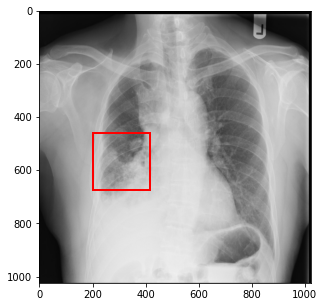

{'boxes': tensor([[250.1895, 518.1215, 436.9471, 706.3811]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8694], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[250.1895, 518.1215, 436.9471, 706.3811]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8694], device='cuda:0')}


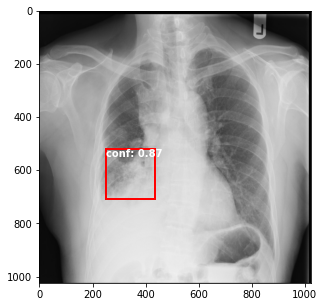

In [ ]:
eval_img(22)

predicted #boxes:  14
real #boxes:  2
EXPECTED OUTPUT
{'boxes': tensor([[285., 430., 447., 592.],
        [626., 457., 864., 695.]]), 'labels': tensor([1, 1]), 'image_id': tensor([32]), 'area': tensor([26244., 56644.]), 'iscrowd': tensor([0, 0])}


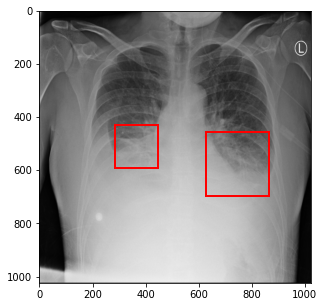

{'boxes': tensor([[617.2919, 411.2898, 874.2484, 667.9029],
        [196.9218, 443.3771, 475.0504, 730.4706]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9097, 0.8368], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[617.2919, 411.2898, 874.2484, 667.9029],
        [196.9218, 443.3771, 475.0504, 730.4706]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9097, 0.8368], device='cuda:0')}


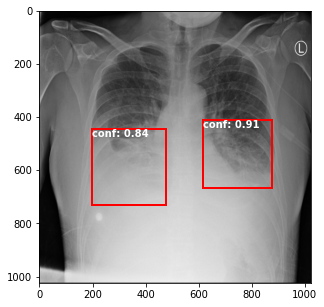

In [ ]:
eval_img(32)

predicted #boxes:  12
real #boxes:  2
EXPECTED OUTPUT
{'boxes': tensor([[600., 300., 931., 631.],
        [235., 283., 518., 566.]]), 'labels': tensor([1, 1]), 'image_id': tensor([45]), 'area': tensor([109561.,  80089.]), 'iscrowd': tensor([0, 0])}


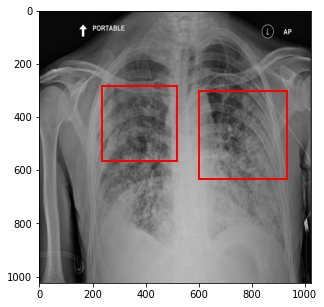

{'boxes': tensor([[218.0704, 238.3058, 475.6494, 496.4738],
        [632.7606, 273.5486, 894.0193, 534.0889]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9493, 0.8996], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[218.0704, 238.3058, 475.6494, 496.4738],
        [632.7606, 273.5486, 894.0193, 534.0889]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9493, 0.8996], device='cuda:0')}


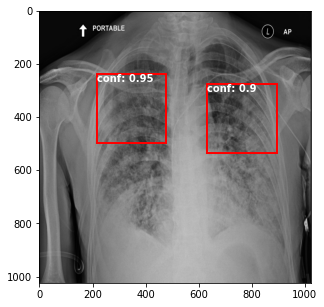

In [ ]:
eval_img(45)

predicted #boxes:  7
real #boxes:  1
EXPECTED OUTPUT
{'boxes': tensor([[504., 265., 766., 527.]]), 'labels': tensor([1]), 'image_id': tensor([326]), 'area': tensor([68644.]), 'iscrowd': tensor([0])}


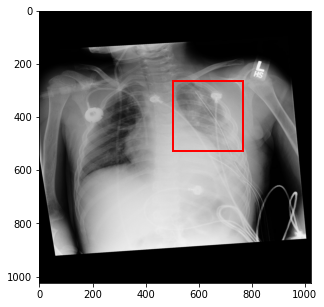

{'boxes': tensor([[524.5280, 290.6746, 757.9615, 537.4587]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8446], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[524.5280, 290.6746, 757.9615, 537.4587]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8446], device='cuda:0')}


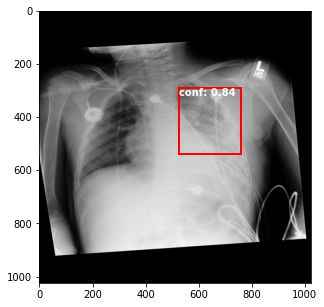

In [ ]:
eval_img(326)

predicted #boxes:  15
real #boxes:  2
EXPECTED OUTPUT
{'boxes': tensor([[ 34., 125., 369., 460.],
        [512., 157., 781., 426.]]), 'labels': tensor([1, 1]), 'image_id': tensor([213]), 'area': tensor([112225.,  72361.]), 'iscrowd': tensor([0, 0])}


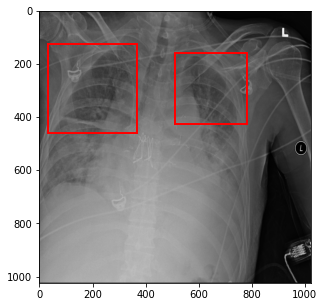

{'boxes': tensor([[ 52.8672, 368.0961, 301.7907, 623.4579],
        [501.0170, 375.1461, 754.8305, 624.1170]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7780, 0.7668], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[ 52.8672, 368.0961, 301.7907, 623.4579],
        [501.0170, 375.1461, 754.8305, 624.1170]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7780, 0.7668], device='cuda:0')}


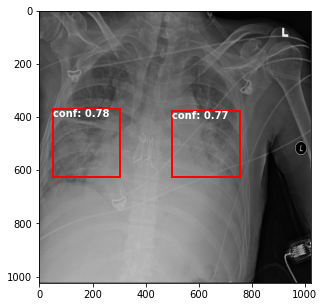

In [ ]:
eval_img(213)

predicted #boxes:  8
real #boxes:  2
EXPECTED OUTPUT
{'boxes': tensor([[727., 564., 845., 682.],
        [438., 618., 588., 768.]]), 'labels': tensor([1, 1]), 'image_id': tensor([432]), 'area': tensor([13924., 22500.]), 'iscrowd': tensor([0, 0])}


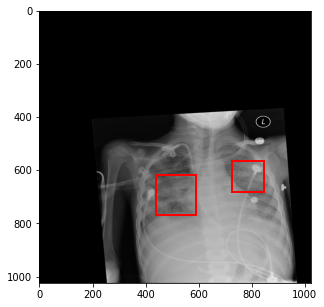

{'boxes': tensor([[397.6279, 609.5678, 577.4500, 791.4000],
        [701.1233, 538.7415, 863.6089, 694.8962]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9350, 0.8805], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[397.6279, 609.5678, 577.4500, 791.4000],
        [701.1233, 538.7415, 863.6089, 694.8962]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9350, 0.8805], device='cuda:0')}


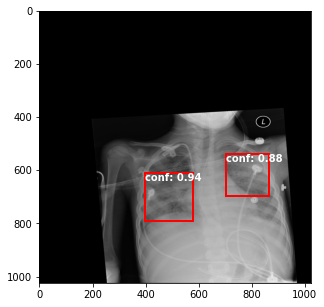

In [ ]:
eval_img(432)

predicted #boxes:  5
real #boxes:  1
EXPECTED OUTPUT
{'boxes': tensor([[577., 485., 843., 751.]]), 'labels': tensor([1]), 'image_id': tensor([190]), 'area': tensor([70756.]), 'iscrowd': tensor([0])}


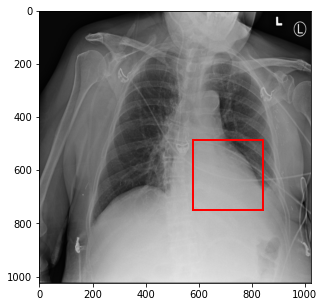

{'boxes': tensor([[617.3903, 533.2527, 836.0608, 744.8892],
        [367.4344, 480.9833, 510.8334, 625.9791]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7745, 0.7587], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[617.3903, 533.2527, 836.0608, 744.8892],
        [367.4344, 480.9833, 510.8334, 625.9791]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7745, 0.7587], device='cuda:0')}


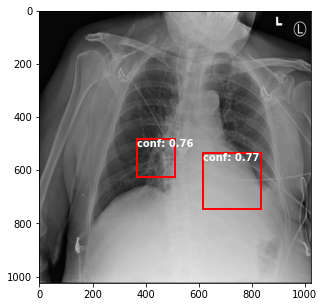

In [ ]:
eval_img(190)

predicted #boxes:  11
real #boxes:  1
EXPECTED OUTPUT
{'boxes': tensor([[202., 340., 436., 574.]]), 'labels': tensor([1]), 'image_id': tensor([342]), 'area': tensor([54756.]), 'iscrowd': tensor([0])}


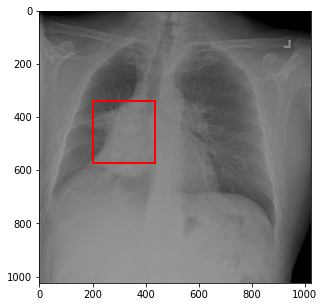

{'boxes': tensor([[192.3491, 352.5642, 427.7458, 584.9750],
        [ 84.9086, 594.6575, 316.6021, 809.3161]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7860, 0.5443], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[192.3491, 352.5642, 427.7458, 584.9750],
        [ 84.9086, 594.6575, 316.6021, 809.3161]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7860, 0.5443], device='cuda:0')}


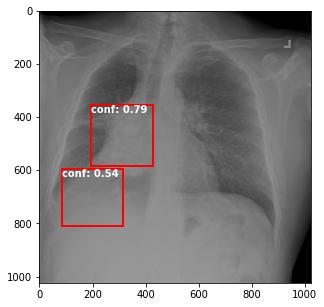

In [ ]:
eval_img(342)

predicted #boxes:  10
real #boxes:  2
EXPECTED OUTPUT
{'boxes': tensor([[553., 326., 780., 553.],
        [231., 374., 448., 591.]]), 'labels': tensor([1, 1]), 'image_id': tensor([382]), 'area': tensor([51529., 47089.]), 'iscrowd': tensor([0, 0])}


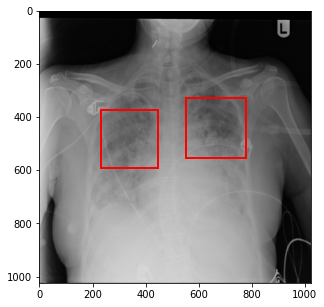

{'boxes': tensor([[184.9810, 318.7999, 439.2224, 570.6017],
        [533.6277, 273.3703, 777.0233, 514.8952]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8743, 0.8487], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[184.9810, 318.7999, 439.2224, 570.6017],
        [533.6277, 273.3703, 777.0233, 514.8952]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8743, 0.8487], device='cuda:0')}


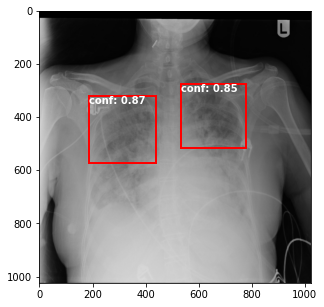

In [ ]:
eval_img(382)

predicted #boxes:  10
real #boxes:  2
EXPECTED OUTPUT
{'boxes': tensor([[178., 352., 442., 616.],
        [563., 436., 857., 730.]]), 'labels': tensor([1, 1]), 'image_id': tensor([183]), 'area': tensor([69696., 86436.]), 'iscrowd': tensor([0, 0])}


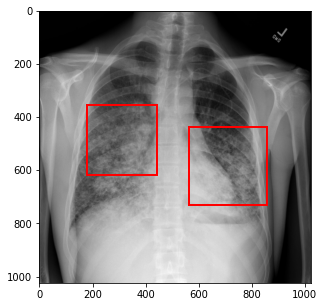

{'boxes': tensor([[154.6266, 355.4569, 430.7154, 631.8024],
        [566.4526, 453.0897, 831.2933, 716.1086]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9343, 0.9041], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[154.6266, 355.4569, 430.7154, 631.8024],
        [566.4526, 453.0897, 831.2933, 716.1086]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9343, 0.9041], device='cuda:0')}


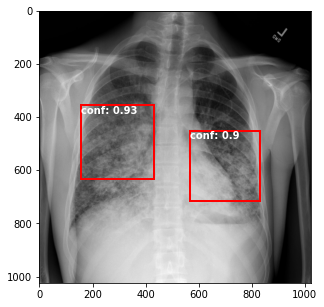

In [ ]:
eval_img(183)

predicted #boxes:  12
real #boxes:  2
EXPECTED OUTPUT
{'boxes': tensor([[628., 301., 932., 605.],
        [260., 299., 534., 573.]]), 'labels': tensor([1, 1]), 'image_id': tensor([304]), 'area': tensor([92416., 75076.]), 'iscrowd': tensor([0, 0])}


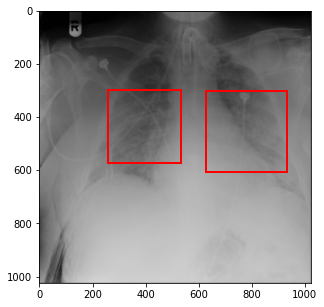

{'boxes': tensor([[649.1187, 215.7927, 977.4390, 553.4073],
        [230.4160, 319.7242, 480.7141, 573.7610]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8611, 0.8164], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[649.1187, 215.7927, 977.4390, 553.4073],
        [230.4160, 319.7242, 480.7141, 573.7610]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8611, 0.8164], device='cuda:0')}


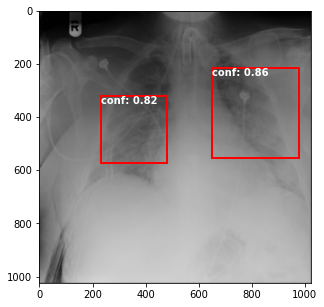

In [ ]:
eval_img(304)

predicted #boxes:  9
real #boxes:  2
EXPECTED OUTPUT
{'boxes': tensor([[642., 277., 885., 520.],
        [315., 309., 541., 535.]]), 'labels': tensor([1, 1]), 'image_id': tensor([233]), 'area': tensor([59049., 51076.]), 'iscrowd': tensor([0, 0])}


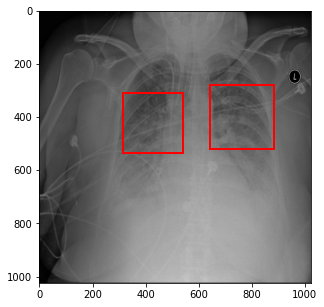

{'boxes': tensor([[652.4128, 222.3427, 873.9064, 442.3242],
        [292.4990, 369.9021, 504.2912, 586.1674]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8563, 0.8527], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[652.4128, 222.3427, 873.9064, 442.3242],
        [292.4990, 369.9021, 504.2912, 586.1674]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8563, 0.8527], device='cuda:0')}


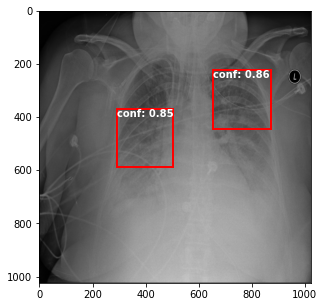

In [ ]:
eval_img(233)

predicted #boxes:  10
real #boxes:  1
EXPECTED OUTPUT
{'boxes': tensor([[196., 460., 393., 657.]]), 'labels': tensor([1]), 'image_id': tensor([51]), 'area': tensor([38809.]), 'iscrowd': tensor([0])}


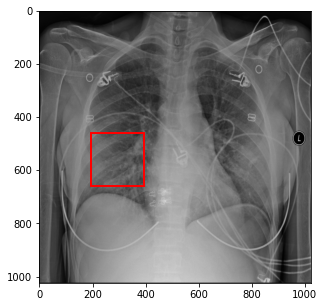

{'boxes': tensor([[183.6119, 468.0469, 409.7185, 688.9965],
        [672.3514, 473.5437, 865.8076, 655.9337]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8579, 0.7979], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[183.6119, 468.0469, 409.7185, 688.9965],
        [672.3514, 473.5437, 865.8076, 655.9337]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8579, 0.7979], device='cuda:0')}


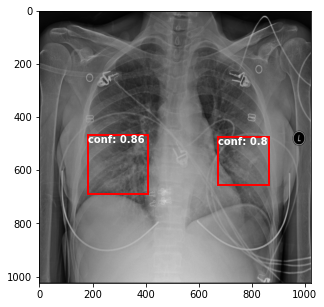

In [ ]:
eval_img(51)

predicted #boxes:  5
real #boxes:  1
EXPECTED OUTPUT
{'boxes': tensor([[181., 330., 382., 531.]]), 'labels': tensor([1]), 'image_id': tensor([230]), 'area': tensor([40401.]), 'iscrowd': tensor([0])}


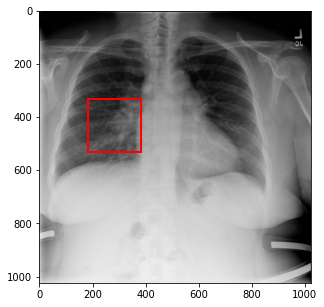

{'boxes': tensor([[182.7840, 364.8305, 360.9630, 542.7618]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7320], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[182.7840, 364.8305, 360.9630, 542.7618]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7320], device='cuda:0')}


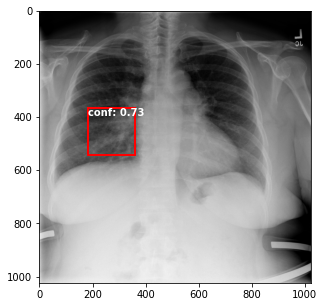

In [ ]:
eval_img(230)

predicted #boxes:  15
real #boxes:  2
EXPECTED OUTPUT
{'boxes': tensor([[631., 461., 958., 788.],
        [238., 456., 509., 727.]]), 'labels': tensor([1, 1]), 'image_id': tensor([102]), 'area': tensor([106929.,  73441.]), 'iscrowd': tensor([0, 0])}


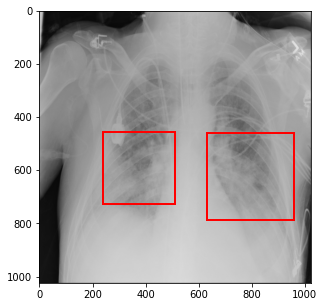

{'boxes': tensor([[649.6606, 514.8022, 914.7719, 774.3011],
        [246.0215, 515.4495, 450.3782, 721.1236],
        [637.7778, 211.5927, 886.9553, 481.8629]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8787, 0.8584, 0.5173], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[649.6606, 514.8022, 914.7719, 774.3011],
        [246.0215, 515.4495, 450.3782, 721.1236],
        [637.7778, 211.5927, 886.9553, 481.8629]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8787, 0.8584, 0.5173], device='cuda:0')}


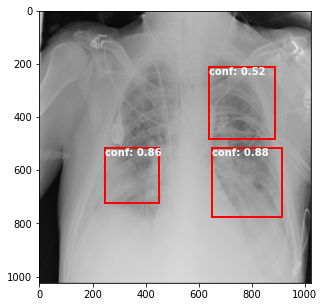

In [ ]:
eval_img(102)

predicted #boxes:  10
real #boxes:  2
EXPECTED OUTPUT
{'boxes': tensor([[719., 400., 853., 534.],
        [262., 347., 491., 576.]]), 'labels': tensor([1, 1]), 'image_id': tensor([271]), 'area': tensor([17956., 52441.]), 'iscrowd': tensor([0, 0])}


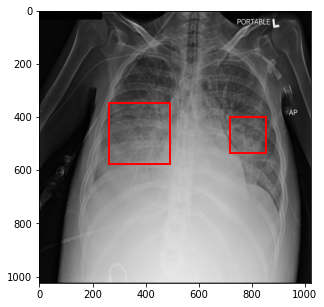

{'boxes': tensor([[251.4175, 319.1238, 495.0217, 564.0554],
        [668.0164, 371.6115, 870.8736, 577.3395]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9321, 0.8442], device='cuda:0')}
NMS APPLIED MODEL OUTPUT
{'boxes': tensor([[251.4175, 319.1238, 495.0217, 564.0554],
        [668.0164, 371.6115, 870.8736, 577.3395]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9321, 0.8442], device='cuda:0')}


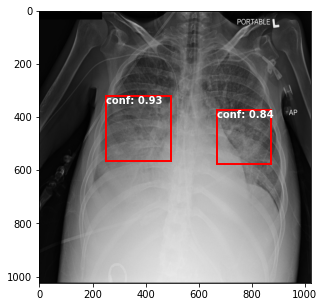

In [ ]:
eval_img(271)

In [ ]:
!pwd

/content/pneumonia_detection
